In [ ]:
pip install twython

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm.notebook import tqdm
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string
import missingno as msno
sns.set(style="whitegrid")


import warnings
warnings.filterwarnings('ignore')

In [ ]:
true = pd.read_csv("true.csv")
fake = pd.read_csv("fake.csv")

In [ ]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [ ]:
true.duplicated().sum()

206

In [ ]:
true.drop_duplicates(inplace=True)

In [ ]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [ ]:
fake.duplicated().sum()

3

In [ ]:
true.drop_duplicates(inplace=True)

In [ ]:
true['label'] = 0
fake['label'] = 1

df = pd.concat([fake, true], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)
df['date'] = pd.to_datetime(df['date'],format='mixed', dayfirst=True,errors='coerce')

df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month_name()

In [ ]:
df.columns = df.columns.str.replace('_', ' ').str.title()

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopword = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text = [stemmer.stem(word) for word in text]
    text = " ".join(text)
    return text

df['Text'] = df['Text'].apply(lambda x: clean(x))
df['Title'] = df['Title'].apply(lambda x: clean(x))

1    23481
0    21211
Name: Label, dtype: int64

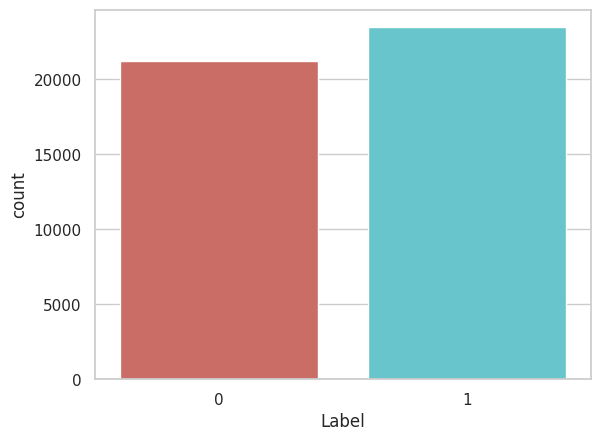

In [ ]:
def create_distribution(dataFile):
    return sns.countplot(x='Label', data=dataFile, palette='hls')

create_distribution(df)

df['Label'].value_counts()

Bi-gram text


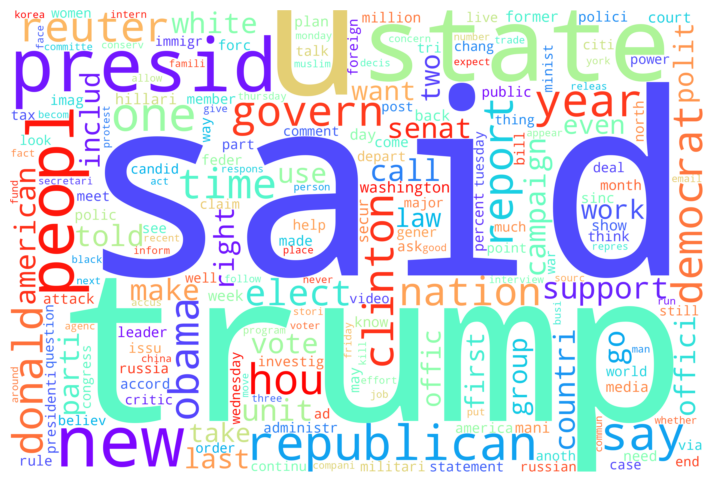

In [ ]:
text = " ".join(df['Text'].astype(str))


wordcloud = WordCloud(width=3000, height=2000, random_state=1, background_color='white', colormap='rainbow', collocations=False, stopwords=STOPWORDS).generate(text)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


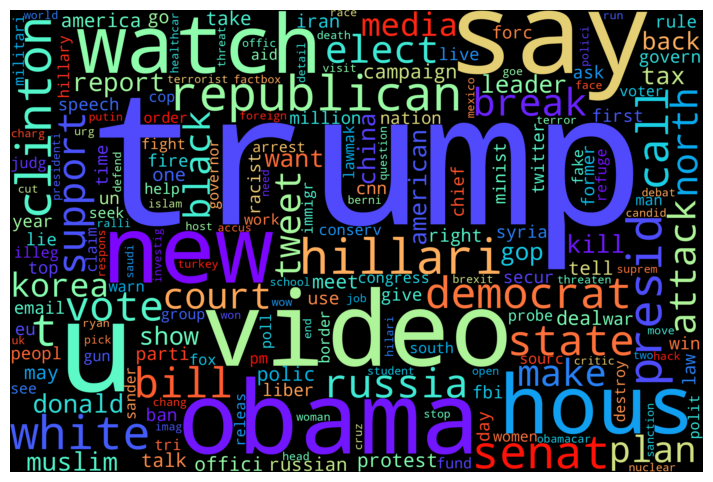

In [ ]:
text = " ".join(df['Title'].astype(str))


wordcloud = WordCloud(width=3000, height=2000, random_state=1, background_color='black', colormap='rainbow', collocations=False, stopwords=STOPWORDS).generate(text)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
sia = SentimentIntensityAnalyzer()
res = {}

for i, row in tqdm(df.iterrows(), total=len(df), desc="Sentiment Analysis"):
    text = row['Text']
    my_id = row['Title']
    res[my_id] = sia.polarity_scores(text)

Sentiment Analysis:   0%|          | 0/44692 [00:00<?, ?it/s]

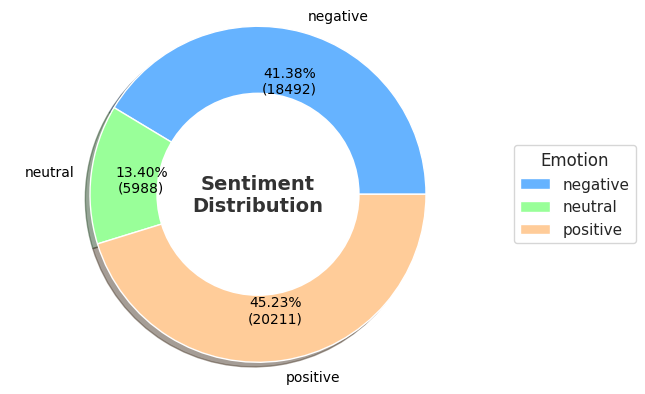

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Title'})
vaders = vaders.merge(df, how='left')
def polarity_score(compound):
    if compound > 0.05:
        return "positive"
    elif compound < -0.5:
        return "negative"
    else:
        return "neutral"

vaders['sentiment'] = vaders['compound'].apply(lambda val: polarity_score(val))
unique_emotion = vaders['sentiment'].unique()

explode = [0] * len(unique_emotion)

emotion_counts = vaders.groupby("sentiment").size()

colors = ['#66b3ff', '#99ff99', '#ffcc99']

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=emotion_counts,
    labels=emotion_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(emotion_counts)/100)})',
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="black"),
    pctdistance=0.7,
    colors=colors,
    explode=explode,
    shadow=True
)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Sentiment\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(emotion_counts.index, title="Emotion", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')

plt.show()

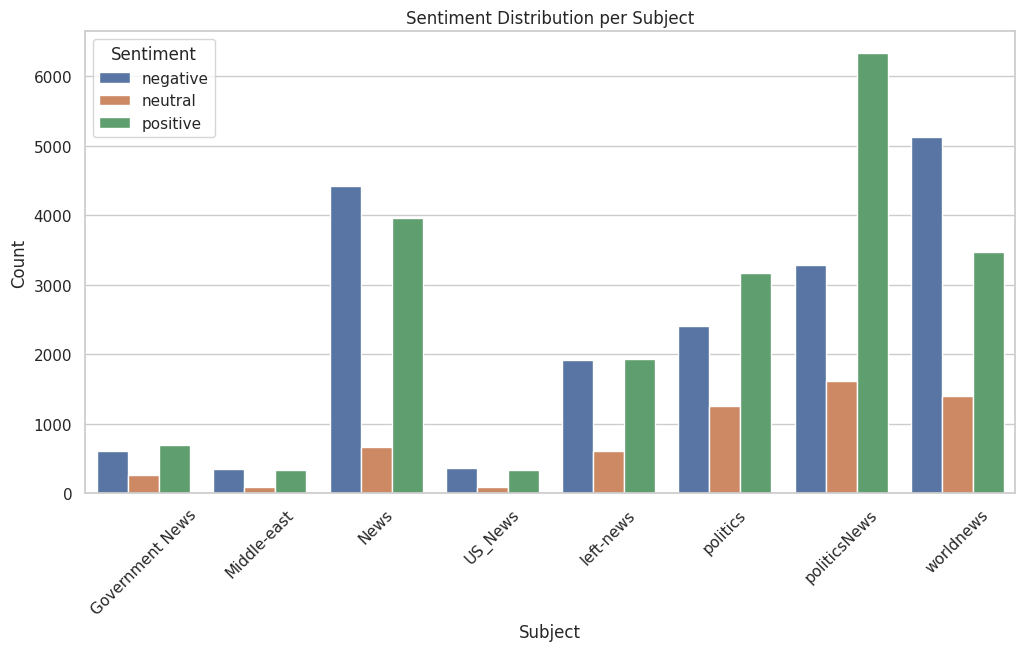

In [ ]:
sentiment_counts = vaders.groupby(['Subject', 'sentiment'])['sentiment'].count().reset_index(name='count')

plt.figure(figsize=(12, 6))
sns.barplot(x='Subject', y='count', hue='sentiment', data=sentiment_counts)

plt.title('Sentiment Distribution per Subject')
plt.xlabel('Subject')
plt.ylabel('Count')

plt.legend(title='Sentiment')

plt.xticks(rotation=45)

plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
df1 = vaders.copy()
df1['content'] = df1['Title'] + ' ' + df1['Text']
X = df1['content']
y = df1['Label']


Data Scaling


In [ ]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(df1['content'].values.reshape(-1, 1), df1['Label'])
X_res = X_res.flatten()
tokenizer = Tokenizer(num_words=50000, oov_token='OOV')
tokenizer.fit_on_texts(X_res)
sequences = tokenizer.texts_to_sequences(X_res)
padded = pad_sequences(sequences, maxlen=1000)

Data Splitting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded, y_res, test_size=0.2, random_state=42)

RNN

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=50000, output_dim=16, input_length=1000))
model.add(SimpleRNN(64, activation='relu', dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 16)          800000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                5184      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 805249 (3.07 MB)
Trainable params: 805249 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

Epoch 1/20
1175/1175 [==============================] - 496s 422ms/step - loss: 0.0609 - accuracy: 0.9806 - val_loss: 0.0728 - val_accuracy: 0.9760
Epoch 2/20
1175/1175 [==============================] - 496s 422ms/step - loss: 0.0364 - accuracy: 0.9886 - val_loss: 0.0587 - val_accuracy: 0.9812
Epoch 3/20
1175/1175 [==============================] - 496s 422ms/step - loss: 0.0374 - accuracy: 0.9881 - val_loss: 0.0726 - val_accuracy: 0.9762
Epoch 4/20
1175/1175 [==============================] - 497s 423ms/step - loss: 0.0723 - accuracy: 0.9810 - val_loss: 0.0685 - val_accuracy: 0.9789


In [ ]:
evaluation_result = model.evaluate(X_test, y_test)

print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

294/294 [==============================] - 16s 54ms/step - loss: 0.0587 - accuracy: 0.9812
Test Loss: 0.0586947537958622
Test Accuracy: 0.9811561703681946


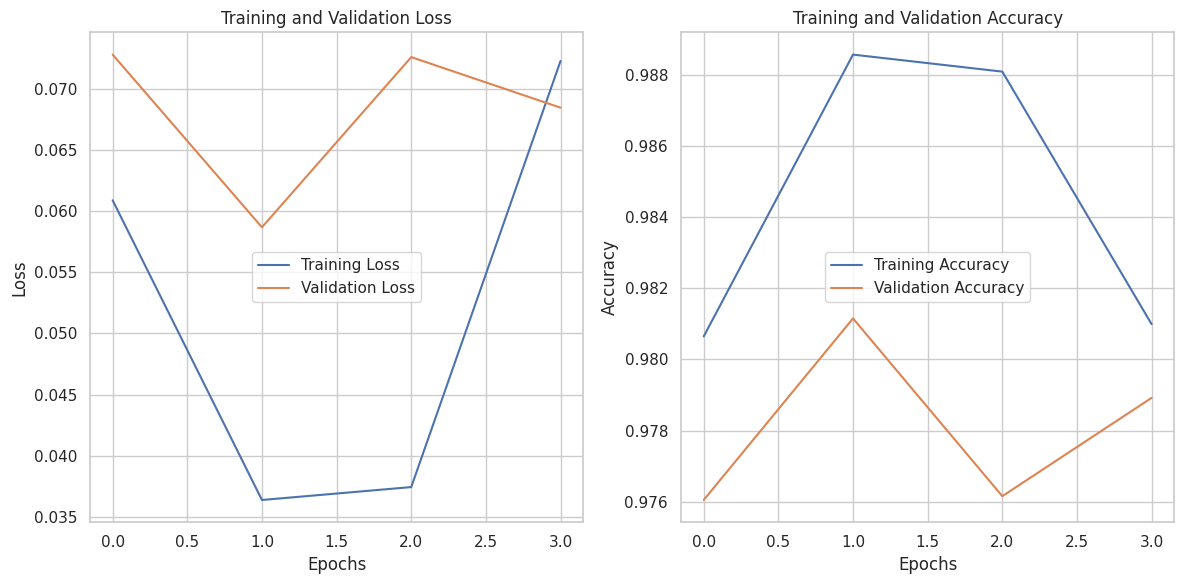

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()